In [288]:
import mne
import glob
import os
import scipy.io
from scipy.spatial.distance import cosine
import numpy as np
from pymatreader import read_mat
import matplotlib.pyplot as plt
from scipy.stats import spearmanr



In [289]:
################################ HELPER FUNCTIONS ################################ 

# create condlist
conditionlist = {
    'leading_Barn': 1,
    'leading_beach': 2,
    'leading_library': 3,
    'leading_restaurant': 4, 
    'leading_cave': 5,
    'trailing_church': 6,
    'trailing_conference_room': 7,
    'trailing_castle': 8, 
    'trailing_forest': 9      
}


# create category dict
#Idea: we create a customised event_id dict that allows us to later just extract the trailing images corresponding to our transitional probabiliy categories

# Mapping VALID CONDITIONS (75%): 
    # leading_barn -> trailing_church
    # leading_beach -> trailing_church
    # leading_library -> trailing_conference_room
    # leading_restaurant ->  trailing_conference_room

# Mapping INVALID CONDITIONS (25%): 
    # leading_barn -> trailing_conference_room
    # leading_beach -> trailing_conference_room
    # leading_library -> trailing_church
    # leading_restaurant -> trailing_church
    
# Mapping CONTROL CONDITIONS (50%): 
    # leading_cave -> trailing_castle
    # leading_cave -> trailing_forest
    
category_dict = {
    0: (1, 6), # valid conditions 75 %
    1: (2, 6), # leading_beach -> trailing_church
    2: (3, 7), # leading_library -> trailing_conference_room
    3: (4, 7),  # leading_restaurant ->  trailing_conference_room
    4: (1, 7), # invalid conditions 0.25 %
    5: (2, 7),
    6: (3, 6), 
    7: (4, 6), 
    8: (5, 8), # control conditions 50 %
    9: (5, 9)
}


rdm_dict = {
    0: (0,1), # 0.75%
    1: (2,3), # 0. 75 % 
    2: (4,5), # 0.25 % 
    3: (6,7), # 0.25 %
    4: (8,), # 0.5 % 
    5: (9,)  # 0.5 %  
}






def convert_trialinfo(data, mapping):
    '''This function converts condition label strings into integer based on the mapping in conditionlist.
        Input: data, condition mapping
        Returns: List of integers
    '''    
    if "trialinfo" in data:
        trialinfo_labels = data["trialinfo"]
    else:
        raise KeyError("'trialinfo' field is missing in data['fD']")

    return np.array([mapping[cond] for cond in trialinfo_labels])


def map_events(event_id, category_dict):
    """
    This function creates a customised event_id dict that allows us to later just extract the trailing images 
    corresponding to our transitional probabiliy categories
    Maps events based on specified (leading, trailing) pairs in category_dict.
    
    Parameters:
    - event_id (list or array-like): List of event IDs.
    - category_dict (dict): Dictionary mapping keys to (leading, trailing) event pairs.
    
    Returns:
    - list: Mapped event categories based on leading-trailing pairs.
    """
    # Initialize event_maps with -1 for each event
    event_maps = [-1] * len(event_id)
    
    # Iterate over event IDs, starting from the second event
    for idx in range(1, len(event_id)):
        # Check if the current and previous event form a valid (leading, trailing) pair
        for key, (leading, trailing) in category_dict.items():
            if idx > 0 and (event_id[idx - 1] == leading) and (event_id[idx] == trailing):
                event_maps[idx] = key
    
    return event_maps




def get_unique_event_ids(event_id):
    """
    Retrieves unique event IDs, excluding the specified unwanted value (-1).
    
    Parameters:
    - event_id (list or array-like): List of event IDs.
    
    Returns:
    - numpy array: Array of unique event IDs, excluding -1.
    """
    # Get unique event IDs and filter out -1
    unique_event_ids = np.unique(event_id)
    unique_event_ids = unique_event_ids[unique_event_ids != -1]
    
    return unique_event_ids



# Define resultspath
results_path_eeg = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/"
#results_path_ann = 





[7 4 7 ... 6 1 7]
Not setting metadata
3455 matching events found
No baseline correction applied
0 projection items activated


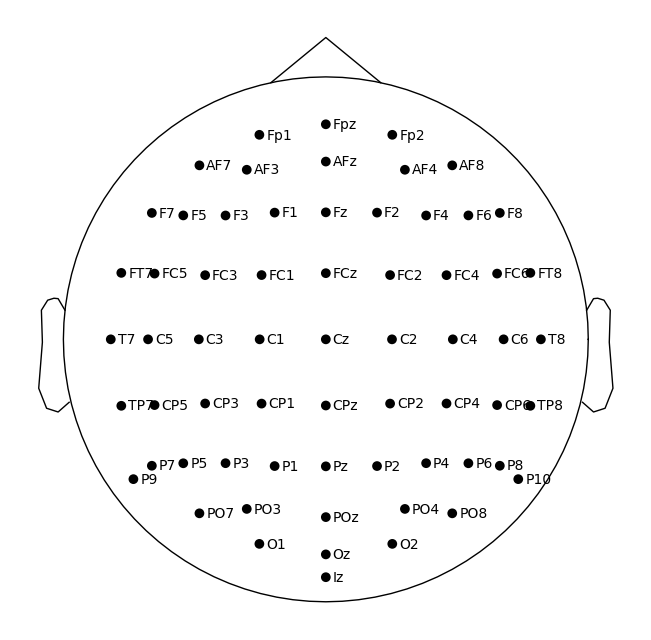

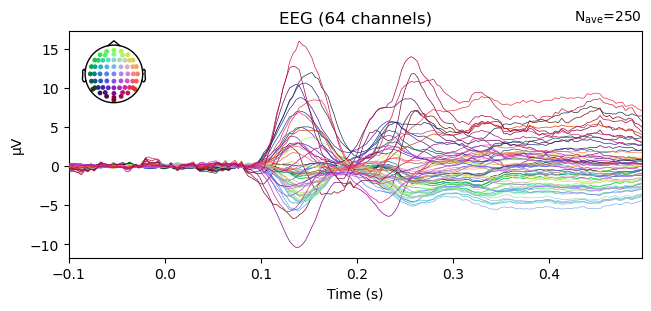

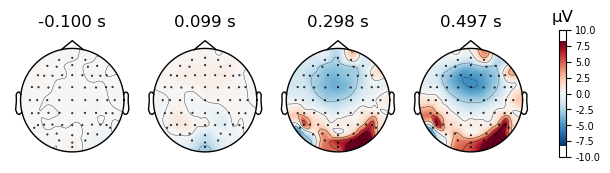

In [126]:
################################ LOAD DATA ################################ 

# Load the FieldTrip .mat file
fname = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/eTadff_sub17.mat"
#fname "/Users/denisekittelmann/Documents/MATLAB/Hannah_data/EEG/P02/fD/eTadff_sub02.mat"
data = read_mat(fname)["fD"]

# Convert string labels into integer labels 
data["trialinfo"] = convert_trialinfo(data, conditionlist)
print(data["trialinfo"])

# read the fields that we will need later
epochs_data = np.array(data["trial"]) * 1e-6 # the mat file says the unit is V, but I think it's actually muV
tmin = data['time'][0][0]
sfreq = int(1. / (data['time'][0][1] - tmin))
ch_names = data["label"]
ch_types = data["elec"]["chantype"]
montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)  # we could read the ch locations from file, but here we just read the cap used in the experiment
# event_dict = {}

event_id = list(data["trialinfo"])
events = np.stack([np.arange(len(event_id)),
                   np.zeros_like(event_id), 
                   event_id], axis=1)
# event_dict <- this will be a useful parameter to set, but we'll need to know what numbers stand for what condition


# create the info field
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create an MNE Epochs object
epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                         events=events, event_id=event_id) 

# set the montage for correct channel positions
epochs = epochs.set_montage(montage)

# plot different events to check if everything sits right
epochs.plot_sensors(show_names=True);
epochs["1"].average().plot();
epochs["2"].average().plot_topomap();

In [ ]:
################################ CREATE CUSTOMISED EVENT ID DICT ################################ 

#Idea: we create a customised event_id dict that allows us to later just extract the trailing images corresponding to our transitional probabiliy categories

# Mapping VALID CONDITIONS (75%): 
    # leading_barn -> trailing_church
    # leading_beach -> trailing_church
    # leading_library -> trailing_conference_room
    # leading_restaurant ->  trailing_conference_room

# Mapping INVALID CONDITIONS (25%): 
    # leading_barn -> trailing_conference_room
    # leading_beach -> trailing_conference_room
    # leading_library -> trailing_church
    # leading_restaurant -> trailing_church
    
# Mapping CONTROL CONDITIONS (50%): 
    # leading_cave -> trailing_castle
    # leading_cave -> trailing_forest
    
category_dict = {
    0: (1, 6), # valid conditions 75 %
    1: (2, 6), # leading_beach -> trailing_church
    2: (3, 7), # leading_library -> trailing_conference_room
    3: (4, 7),  # leading_restaurant ->  trailing_conference_room
    4: (1, 7), # invalid conditions 0.25 %
    5: (2, 7),
    6: (3, 6), 
    7: (4, 6), 
    8: (5, 8), # control conditions 50 %
    9: (5, 9)
}


rdm_dict = {
    0: (0,1), # 0.75%
    1: (2,3), # 0. 75 % 
    2: (4,5), # 0.25 % 
    3: (6,7), # 0.25 %
    4: (8,), # 0.5 % 
    5: (9,)  # 0.5 %  
}




event_maps = [-1] * len(event_id)
for idx in range(1, len(event_id)):
    #print("idx:", idx)
    # Check if the current and previous event form a valid (leading, trailing) pair
    for key, (leading, trailing) in category_dict.items():
        if idx > 0 and (event_id[idx - 1] == leading) and (event_id[idx] == trailing):
            event_maps[idx] = key
                       
#event_id = event_maps



In [107]:
def read_custom_epochs(data):
    # Read .mat file and extract required data
    #data = read_mat(fname)["fD"] 
    data = data
    # Extract and process relevant fields
    epochs_data = np.array(data["trial"]) * 1e-6  # Assuming data is in muV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = data["elec"]["chantype"]
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)
    
    # Extract event information
    event_id = list(data["trialinfo"]) # categories 1-9 
    events = np.stack([np.arange(len(event_id)),
                       np.zeros_like(event_id), 
                       event_id], axis=1)

    # Create the MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create the MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                             events=events, event_id=event_id)

    # Set the montage for channel positions
    epochs = epochs.set_montage(montage)

    # Plot to verify
    #epochs.plot_sensors(show_names=True)
    #epochs["5"].average().plot()
    #epochs["leading_restaurant"].average().plot_topomap()

    return epochs

In [111]:
def read_custom_epochs(data, event_id, event_codes):
    """
    Reads and processes EEG epochs from a structured data dictionary.
    
    Parameters:
    - data (dict): Dictionary containing trial data, time, labels, and trial info.
    - event_id (dict): Mapping of event names to integer codes.
    - event_codes (array): Array of event codes matching the epochs.
    
    Returns:
    - mne.EpochsArray: MNE epochs object with the specified event structure.
    """
    # Process the epochs data (converting units if in microvolts)
    epochs_data = np.array(data["trial"]) * 1e-6  # Assuming data is in µV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = ["eeg"] * len(ch_names)  # Assuming all channels are EEG, update if needed

    # Define montage for electrode positions
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)

    # Create the `events` array with format (index, 0, event_code)
    events = np.column_stack((np.arange(len(event_codes)), np.zeros(len(event_codes), int), event_codes))

    # Create the MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create the MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin, events=events, event_id=event_id)

    # Set the montage for channel positions
    epochs.set_montage(montage)

    return epochs

In [290]:
################################ COMPUTE EEG RDM ################################ 

# Define dir where EEG can be found 
dir = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/"

# Create iterator
ids = [pid for pid in range(1, 32) if pid != 20] 

# Loop over all participants and compute EEG RDMs for each hypothesis
for pid in ids:
    
    print(pid)

    fname = os.path.join(dir, f"eTadff_sub{pid:02d}.mat")
    print(f"Loading data for participant {pid} from file {fname}")
    data = read_mat(fname)["fD"]

    data["trialinfo"] = convert_trialinfo(data, conditionlist)
    print(data["trialinfo"])
    

    # read the fields that we will need later
    epochs_data = np.array(data["trial"]) * 1e-6 # muV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = data["elec"]["chantype"]
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)  
    # event_dict = {}

    event_id = list(data["trialinfo"])
    events = np.stack([np.arange(len(event_id)),
                    np.zeros_like(event_id), 
                    event_id], axis=1)
    
    # create the info field
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create an MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                            events=events, event_id=event_id) 

    # set the montage for correct channel positions
    epochs = epochs.set_montage(montage)

    
    event_id = map_events(event_id, category_dict)
    print("event_id:",event_id)


    ################################ COMPUTE EEG RDM ################################ 
    print(f"################################ Preparing to compute RDMs for participant {pid:02d} ################################")
    
    # Construct empty RDMs
    n_categories = len(rdm_dict)
    rdm_b1 = np.zeros((n_categories, n_categories))
    rdm_b2 = np.zeros((n_categories, n_categories))
    rdm_early = np.zeros((n_categories, n_categories))
    rdm_late = np.zeros((n_categories, n_categories))
    
    # Define time windows for H2
    early_start, early_end = 0.128, 0.180
    late_start, late_end = 0.280, 0.296

    epochs_early = epochs.copy().crop(tmin=early_start, tmax=early_end)
    epochs_late = epochs.copy().crop(tmin=late_start, tmax=late_end)
    
    b1 = epochs[:len(epochs) // 2]
    b2 = epochs[len(epochs) // 2:]


    # Compute EEG RDMs for each participant
    print(f"################################ Starting to compute RDMs for participant {pid:02d} ################################")
    
    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [b1[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [b1[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_b1[i, j] = cosine(mean_representation_i, mean_representation_j)
            

    print(f"################################ Finished computing RDM_B1 for participant {pid:02d}. STARTING DO COMPUTE RDM_B2. ################################")
    
    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [b2[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [b2[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_b2[i, j] = cosine(mean_representation_i, mean_representation_j)
            np.save(os.path.join(results_path_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy"), rdm_b2)
 
    print(f"################################ Finished computing RDM_B2 for participant {pid:02d}. STARTING DO COMPUTE RDM_EARLY. ################################")

    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [epochs_early[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [epochs_early[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_early[i, j] = cosine(mean_representation_i, mean_representation_j)
            np.save(os.path.join(results_path_eeg, f"eeg_rdm_late_sub{pid:02d}.npy"), rdm_late)

    print(f"################################ Finished computing RDM_EARLY for participant {pid:02d}. STARTING DO COMPUTE RDM_LATE. ################################")
    
    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [epochs_late[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [epochs_late[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_late[i, j] = cosine(mean_representation_i, mean_representation_j)
            np.save(os.path.join(results_path_eeg, f"eeg_rdm_early_sub{pid:02d}.npy"), rdm_early)
            
    print(f"################################ Finished computing RDM_B2 for participant {pid:02d} ################################")

    print(f"################################ Saving RDMs for participant {pid:02d} ################################")
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_b1_sub{pid:02d}.npy"), rdm_b1)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy"), rdm_b2)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_early_sub{pid:02d}.npy"), rdm_early)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_late_sub{pid:02d}.npy"), rdm_late)


# convert correction to z test on sample t-test 
# pearson correlation correlations to z score  ->  at the group level; fishers rank correlation parametric way more producible 
# standard fehler sample size  -> alle einträge in der der matrix -> 9 X 9 
# 
# scipy rank correlation  before flatten
    
        

1
Loading data for participant 1 from file /Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/eTadff_sub01.mat
[3 7 4 ... 6 1 7]
Not setting metadata
3456 matching events found
No baseline correction applied
0 projection items activated
event_id: [-1, 2, -1, 3, -1, 0, -1, 1, -1, 9, -1, 9, -1, 9, -1, 8, -1, 1, -1, 4, -1, 1, -1, 2, -1, 1, -1, 9, -1, 1, -1, 2, -1, 2, -1, 2, -1, 3, -1, 3, -1, 1, -1, 8, -1, 8, -1, 9, -1, 7, -1, 2, -1, 7, -1, 3, -1, 8, -1, 9, -1, 0, -1, 9, -1, 3, -1, 8, -1, 9, -1, 8, -1, 1, -1, 7, -1, 8, -1, 9, -1, 8, -1, 3, -1, 8, -1, 8, -1, 9, -1, 1, -1, 1, -1, 1, -1, 0, -1, 0, -1, 3, -1, 5, -1, 2, -1, 8, -1, 8, -1, 8, -1, 8, -1, 8, -1, 1, -1, 2, -1, 1, -1, 8, -1, 1, -1, 0, -1, 4, -1, 1, -1, 3, -1, 1, -1, 9, -1, 3, -1, 1, -1, 6, -1, 2, -1, 8, -1, 1, -1, 8, -1, 5, -1, 1, -1, 8, -1, 2, -1, 9, -1, 8, -1, 9, -1, 6, -1, 1, -1, 6, -1, 9, -1, 3, -1, 5, -1, 0, -1, 3, -1, 6, -1, 3, -1, 1, -1, 9, -1, 6, -1, 8, -1, 8, -1, 9, -1, 8, -1, 1, -1, 0, -1, 9, -1, 4, -1, 2, -1, 0, -1, 6

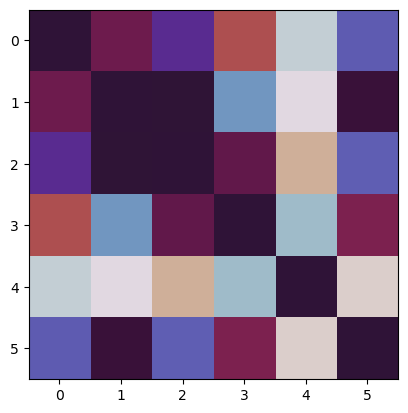

In [299]:
################################ PLOT EEG RDMs ################################ 

# just a quick visual check whether everything worked out correctly

rdm = np.load('/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/eeg_rdm_b1_sub06.npy')
plt.imshow(rdm, cmap='twilight_shifted') # twilight_shifted inferno plasma 
#plt.xticks([])
#plt.yticks([])
plt.show()
plt.close()

In [300]:
################################ COMPUTE SIMILARITY BETWEEN RDMs ################################ 

# Spearman’s correlation 

# Define dir where EEG can be found 
dir_rdms_eeg = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/"

dir_rdm_pcnh1_acts = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h1_pcn_act.npy"
dir_rdm_pcnh1_err = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h1_pcn_error.npy"
dir_rdm_pcnh23_l1 = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h23_pcn_l1.npy"
dir_rdm_pcn23_l2 = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h23_pcn_l2.npy"

dir_rdm_bph1 = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/backprop/rdm_h1_bp.npy"

rdm_pcn_h1_act = np.load(dir_rdm_pcnh1_acts)
rdm_pcn_h1_err = np.load(dir_rdm_pcnh1_err)
rdm_bp = np.load(dir_rdm_bph1)

rdm_pcn_h23_l1 = np.load(dir_rdm_pcnh23_l1)
rdm_pcn_h23_l2 = np.load(dir_rdm_pcn23_l2)

# Only extract lower triangle without diagonal 
def get_lower_triangle(rdm):
    """
    Extracts and flattens the lower triangle of an RDM without the diagonal.
    
    Parameters:
    rdm (np.array): A symmetric RDM matrix (e.g., 6x6).
    
    Returns:
    np.array: Flattened lower triangle values without the diagonal.
    """
    mask = np.tril(np.ones_like(rdm), k=-1)
    lower_triangle_with_nan = np.where(mask == 1, rdm, np.nan)
    rdm_new = lower_triangle_with_nan[~np.isnan(lower_triangle_with_nan)]
    return rdm_new

  
rdm_pcn_h1_act_lt = get_lower_triangle(rdm_pcn_h1_act)
rdm_pcn_h1_err_lt = get_lower_triangle(rdm_pcn_h1_err)
rdm_bp_lt = get_lower_triangle(rdm_bp)

rdm_pcn_h23_l1_lt = get_lower_triangle(rdm_pcn_h23_l1)
rdm_pcn_h23_l2_lt = get_lower_triangle(rdm_pcn_h23_l2)


lr_PCN_h1_act = []
lr_PCN_h1_err = []
lr_BPN_h1 = []

lr_PCN_h2_early_l1 = []
lr_PCN_h2_early_l2 = []
lr_PCN_h2_late_l1 = []
lr_PCN_h2_late_l2 = []

lr_PCN_h3_b1_l1 = []
lr_PCN_h3_b1_l2= []
lr_PCN_h3_b2_l1 = []
lr_PCN_h3_b2_l2= []


ids = [pid for pid in range(1, 32) if pid != 20] 

for pid in ids:
    print(f"################################ Computing Corr for H1 for participant {pid:02d} ################################")
    fname_b2 = os.path.join(dir_rdms_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy")

    rdm_sub = np.load(fname_b2)
    rdm_sub_lt = get_lower_triangle(rdm_sub)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_lt)
    #print(f"Lower triangle for participant {pid}:\n", rdm_sub_late_lt)


    r_PCN_h1 = spearmanr(rdm_sub_lt, rdm_pcn_h1_act_lt, axis=None)  
    r_PCN_h1_err =  spearmanr(rdm_sub_lt, rdm_pcn_h1_err_lt, axis=None)  
    r_BPN_h1 = spearmanr(rdm_sub_lt, rdm_bp_lt, axis=None) 
    print(f"Lower corr b2 acts for participant {pid}:\n", r_PCN_h1)
    print(f"Lower corr b2 err for participant {pid}:\n", r_PCN_h1_err)
    print(f"Lower corr b2 bp for participant {pid}:\n", r_BPN_h1)

    lr_PCN_h1_act.append(r_PCN_h1)
    lr_PCN_h1_err.append(r_PCN_h1_err)
    lr_BPN_h1.append(r_BPN_h1)


# H2 
for pid in ids:
    
    print(f"################################ Computing Corr for H2 for participant {pid:02d} ################################")
    fname_b2 = os.path.join(dir_rdms_eeg, f"eeg_rdm_early_sub{pid:02d}.npy")
    fname_b3 = os.path.join(dir_rdms_eeg, f"eeg_rdm_late_sub{pid:02d}.npy")

    rdm_sub_early = np.load(fname_b2)
    rdm_sub_late = np.load(fname_b3)
    
    rdm_sub_early_lt = get_lower_triangle(rdm_sub_early)
    rdm_sub_late_lt = get_lower_triangle(rdm_sub_late)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_early_lt)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_late_lt)


    r_PCN_early_l1 = spearmanr(rdm_sub_early_lt, rdm_pcn_h23_l1_lt, axis=None)  
    r_PCN_early_l2 = spearmanr(rdm_sub_early_lt, rdm_pcn_h23_l2_lt, axis=None) 
    print(f"Lower corr early l1 for participant {pid}:\n", r_PCN_early_l1)
    print(f"Lower corr early l2 for participant {pid}:\n", r_PCN_early_l2)
    
    r_PCN_late_l1 = spearmanr(rdm_sub_late_lt, rdm_pcn_h23_l1_lt, axis=None)  
    r_PCN_late_l2 = spearmanr(rdm_sub_late_lt, rdm_pcn_h23_l2_lt, axis=None) 

    lr_PCN_h2_early_l1.append(r_PCN_early_l1)
    lr_PCN_h2_early_l2.append(r_PCN_early_l2)
    lr_PCN_h2_late_l1.append(r_PCN_late_l1)
    lr_PCN_h2_late_l2.append(r_PCN_late_l2) 

# H3

for pid in ids:
    
    print(f"################################ Computing Corr for H3 for participant {pid:02d} ################################")
    fname_b2 = os.path.join(dir_rdms_eeg, f"eeg_rdm_b1_sub{pid:02d}.npy")
    fname_b3 = os.path.join(dir_rdms_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy")

    rdm_sub_b1 = np.load(fname_b2)
    rdm_sub_b2 = np.load(fname_b3)
    
    rdm_sub_b1_lt = get_lower_triangle(rdm_sub_b1)
    rdm_sub_b2_lt = get_lower_triangle(rdm_sub_b2)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_b1_lt)
    print(f"Lower triangle for participant {pid}:\n", rdm_sub_b2_lt)

    r_PCN_h3_b1_l1 = spearmanr(rdm_sub_b1_lt, rdm_pcn_h23_l1_lt, axis=None)  
    r_PCN_h3_b1_l2 = spearmanr(rdm_sub_b1_lt, rdm_pcn_h23_l2_lt, axis=None) 
    
    r_PCN_h3_b2_l1 = spearmanr(rdm_sub_b2_lt, rdm_pcn_h23_l1_lt, axis=None)  
    r_PCN_h3_b2_l2 = spearmanr(rdm_sub_b2_lt, rdm_pcn_h23_l2_lt, axis=None) 

    lr_PCN_h3_b1_l1.append(r_PCN_h3_b1_l1)
    lr_PCN_h3_b1_l2.append(r_PCN_h3_b1_l2)
    lr_PCN_h3_b2_l1.append(r_PCN_h3_b2_l1)
    lr_PCN_h3_b2_l2.append(r_PCN_h3_b2_l2)

    
    


################################ Computing Corr for H1 for participant 01 ################################
Lower triangle for participant 1:
 [0.64218429 0.16860419 0.57436435 1.19042088 0.93637067 1.21275319
 0.38178693 0.7691134  0.39206755 1.20335091 0.96382362 0.84286472
 0.94098803 0.81152276 1.20490981]
Lower corr b2 acts for participant 1:
 SignificanceResult(statistic=-0.10357142857142855, pvalue=0.7133796306287292)
Lower corr b2 err for participant 1:
 SignificanceResult(statistic=0.30357142857142855, pvalue=0.27135583600386853)
Lower corr b2 bp for participant 1:
 SignificanceResult(statistic=-0.13214285714285715, pvalue=0.6387442188840665)
################################ Computing Corr for H1 for participant 02 ################################
Lower triangle for participant 2:
 [0.87954523 0.50899444 0.65641027 0.8366916  0.81240695 0.7672249
 0.84030932 0.73353097 0.69514596 0.81307738 0.88213271 0.634131
 0.59529411 0.78566641 0.58101024]
Lower corr b2 acts for participan

In [276]:
fname_b2 = os.path.join(dir_rdms_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy")
fname_b2

'/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/eeg_rdm_b2_sub31.npy'

In [273]:
lr_PCN_h3_b1_l2

[SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.742045009907367),
 SignificanceResult(statistic=0.09285714285714285, pvalue=0.7420

In [ ]:
dir_rdm_pcnh1_acts = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h1_pcn_act.npy"
rdm_pcn_h1_act = np.load(dir_rdm_pcnh1_acts)


mask = np.tril(np.ones_like(rdm_pcn_h1_act), k=-1)

# Apply the mask to retain only the lower triangle without the diagonal
lower_triangle_with_nan = np.where(mask == 1, rdm_pcn_h1_act, np.nan)
lower_triangle_with_nan
data_without_nan = lower_triangle_with_nan[~np.isnan(lower_triangle_with_nan)]

print(rdm_pcn_h1_act)
print(data_without_nan)

dm_pcn_h1_act = np.array([
    [1.14607290e-09, 2.74127930e-04, 1.82935642e-04, 1.45249939e-04, 5.74688216e-04, 3.91994121e-04],
    [2.74127930e-04, 4.51753468e-09, 1.35856376e-04, 1.86163673e-04, 3.95863311e-04, 3.19846225e-04],
    [1.82935642e-04, 1.35856376e-04, 8.44680215e-09, 3.76059637e-04, 4.74215338e-04, 4.20383782e-04],
    [1.45249939e-04, 1.86163673e-04, 3.76059637e-04, 0.00000000e+00, 5.47198959e-04, 3.40584894e-04],
    [5.74688216e-04, 3.95863311e-04, 4.74215338e-04, 5.47198959e-04, 1.23463635e-08, 6.16219735e-05],
    [3.91994121e-04, 3.19846225e-04, 4.20383782e-04, 3.40584894e-04, 6.16219735e-05, 1.61949495e-08]
])

# Create a mask for the lower triangle without the diagonal
mask = np.tril(np.ones_like(rdm_pcn_h1_act), k=-1)
lower_triangle_with_nan = np.where(mask == 1, rdm_pcn_h1_act, np.nan)
t_data_without_nan = lower_triangle_with_nan[~np.isnan(lower_triangle_with_nan)]

print("Lower Triangle with NaN:\n", t_data_without_nan)

[[1.14607290e-09 2.74127930e-04 1.82935642e-04 1.45249939e-04
  5.74688216e-04 3.91994121e-04]
 [2.74127930e-04 4.51753468e-09 1.35856376e-04 1.86163673e-04
  3.95863311e-04 3.19846225e-04]
 [1.82935642e-04 1.35856376e-04 8.44680215e-09 3.76059637e-04
  4.74215338e-04 4.20383782e-04]
 [1.45249939e-04 1.86163673e-04 3.76059637e-04 0.00000000e+00
  5.47198959e-04 3.40584894e-04]
 [5.74688216e-04 3.95863311e-04 4.74215338e-04 5.47198959e-04
  1.23463635e-08 6.16219735e-05]
 [3.91994121e-04 3.19846225e-04 4.20383782e-04 3.40584894e-04
  6.16219735e-05 1.61949495e-08]]
[2.74127930e-04 1.82935642e-04 1.35856376e-04 1.45249939e-04
 1.86163673e-04 3.76059637e-04 5.74688216e-04 3.95863311e-04
 4.74215338e-04 5.47198959e-04 3.91994121e-04 3.19846225e-04
 4.20383782e-04 3.40584894e-04 6.16219735e-05]
Lower Triangle with NaN:
 [2.74127930e-04 1.82935642e-04 1.35856376e-04 1.45249939e-04
 1.86163673e-04 3.76059637e-04 5.74688216e-04 3.95863311e-04
 4.74215338e-04 5.47198959e-04 3.91994121e-04 3.198

array([2.74127930e-04, 1.82935642e-04, 1.35856376e-04, 1.45249939e-04,
       1.86163673e-04, 3.76059637e-04, 5.74688216e-04, 3.95863311e-04,
       4.74215338e-04, 5.47198959e-04, 3.91994121e-04, 3.19846225e-04,
       4.20383782e-04, 3.40584894e-04, 6.16219735e-05])

In [ ]:
import numpy as np

# Example 6x6 matrix
matrix = np.random.rand(6, 6)

# Create a mask for the lower triangle without the diagonal
mask = np.tril(np.ones_like(matrix), k=-1)
print(mas)

# Apply the mask to get only the lower triangle without the diagonal
lower_triangle_without_diag = matrix * mask

# Display the result
print(lower_triangle_without_diag)


[[0.         0.         0.         0.         0.         0.        ]
 [0.27702795 0.         0.         0.         0.         0.        ]
 [0.6889904  0.13617259 0.         0.         0.         0.        ]
 [0.7602626  0.75039363 0.51596901 0.         0.         0.        ]
 [0.62759048 0.98539722 0.84943898 0.93067854 0.         0.        ]
 [0.9242968  0.85245276 0.95968482 0.81332031 0.99505477 0.        ]]


In [255]:
import numpy as np
from scipy.stats import spearmanr

# Example 6x6 matrix
matrix = np.random.rand(6, 6)

# Create a mask for the lower triangle without the diagonal
mask = np.tril(np.ones_like(matrix), k=-1)

# Apply the mask and convert zeros to NaN
lower_triangle_with_nan = np.where(mask == 1, matrix, np.nan)
print(lower_triangle_with_nan)

# Flatten the matrix and remove NaN values for Spearman calculation
data_without_nan = lower_triangle_with_nan[~np.isnan(lower_triangle_with_nan)]
print(data_without_nan)

# Assuming you have another dataset `other_data` to compare with
# Flatten it similarly and remove NaNs as needed
# other_data = ...

# Calculate Spearman correlation (example uses the same data for illustration)
corr, p_value = spearmanr(lower_triangle_with_nan, lower_triangle_with_nan)  # Replace with `other_data` for real comparison

print("Spearman correlation:", corr)
print("p-value:", p_value)


[[       nan        nan        nan        nan        nan        nan]
 [0.38266155        nan        nan        nan        nan        nan]
 [0.46519434 0.63792374        nan        nan        nan        nan]
 [0.02589338 0.23177627 0.81306923        nan        nan        nan]
 [0.51832163 0.07409731 0.41871503 0.23393662        nan        nan]
 [0.96987667 0.04620127 0.56830154 0.89118738 0.22523987        nan]]
[0.38266155 0.46519434 0.63792374 0.02589338 0.23177627 0.81306923
 0.51832163 0.07409731 0.41871503 0.23393662 0.96987667 0.04620127
 0.56830154 0.89118738 0.22523987]
Spearman correlation: [[nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan

In [257]:
import numpy as np

# Example symmetric 6x6 matrix (with random values for illustration)
matrix = np.random.rand(6, 6)
matrix = (matrix + matrix.T) / 2  # Make the matrix symmetric

# Create a mask for the lower triangle without the diagonal
mask = np.tril(np.ones_like(matrix), k=-1)

# Apply the mask to retain only the lower triangle without the diagonal
lower_triangle_with_nan = np.where(mask == 1, matrix, np.nan)

print("Symmetric Matrix:\n", matrix)
print("\nMask:\n", mask)
print("\nLower Triangle with NaN:\n", lower_triangle_with_nan)


Symmetric Matrix:
 [[0.96887234 0.46569385 0.59245141 0.2526576  0.58356231 0.7346202 ]
 [0.46569385 0.72472109 0.29813869 0.24083151 0.40992844 0.62915977]
 [0.59245141 0.29813869 0.21499554 0.68857666 0.59082659 0.7272974 ]
 [0.2526576  0.24083151 0.68857666 0.36844471 0.61745052 0.79830041]
 [0.58356231 0.40992844 0.59082659 0.61745052 0.38635742 0.59219695]
 [0.7346202  0.62915977 0.7272974  0.79830041 0.59219695 0.10586953]]

Mask:
 [[0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0.]]

Lower Triangle with NaN:
 [[       nan        nan        nan        nan        nan        nan]
 [0.46569385        nan        nan        nan        nan        nan]
 [0.59245141 0.29813869        nan        nan        nan        nan]
 [0.2526576  0.24083151 0.68857666        nan        nan        nan]
 [0.58356231 0.40992844 0.59082659 0.61745052        nan        nan]
 [0.7346202  0.62915977 0.7272974  0.79830041 0.59219695   

In [ ]:
import numpy as np
from scipy.stats import spearmanr

# Example 6x6 matrix
matrix = np.random.rand(6, 6)

# Create a mask for the lower triangle without the diagonal
mask = np.tril(np.ones_like(matrix), k=-1)

# Create a condition labels matrix (could be numbers or strings for each condition)
condition_labels = np.array([
    ["BA-CH", "", "", "", "", ""],
    ["BE-CH", "A-B", "", "", "", ""],
    ["E-F", "G-H", "C-D", "", "", ""],
    ["I-J", "K-L", "M-N", "E-F", "", ""],
    ["O-P", "Q-R", "S-T", "U-V", "I-J", ""],
    ["W-X", "Y-Z", "AA-BB", "CC-DD", "EE-FF", "O-P"]
])

# Apply the mask to get lower triangle values without diagonal
lower_triangle_with_nan = np.where(mask == 1, matrix, np.nan)

# Flatten the matrix and labels, then remove NaNs from both
flat_values = lower_triangle_with_nan.flatten()
flat_labels = condition_labels.flatten()

# Filter out NaN values and their corresponding labels
filtered_values = flat_values[~np.isnan(flat_values)]
filtered_labels = flat_labels[~np.isnan(flat_values)]

# Display the results
for label, value in zip(filtered_labels, filtered_values):
    print(f"Condition {label}: {value}")

# Example correlation calculation if you have another dataset to compare with
# Flatten the other data and filter similarly, then calculate spearmanr
# other_data = ...
# filtered_other_data = ...

# corr, p_value = spearmanr(filtered_values, filtered_other_data)


Condition C-D: 0.44564129703980626
Condition E-F: 0.58680263233426
Condition G-H: 0.6429012115423948
Condition I-J: 0.6861495836382546
Condition K-L: 0.9458976703088815
Condition M-N: 0.8370514603588055
Condition O-P: 0.8964801610282312
Condition Q-R: 0.5070459668975512
Condition S-T: 0.29870240034274786
Condition U-V: 0.7144549742048475
Condition W-X: 0.12057272810934905
Condition Y-Z: 0.14987234218694745
Condition AA-BB: 0.002466235590183663
Condition CC-DD: 0.3843630476315477
Condition EE-FF: 0.19932797265070035


In [ ]:
################################ STATISTICALLY TEST SIMILARITIES ################################ 

# non parametric test: permutation test? -> nur replicable with z scoring 

# Perform Fisher's Z transformation on all correlation values 
def z_transform(r, n):
    z = np.log((1 + r) / (1 - r)) * (np.sqrt(n - 3) / 2)
    #p = zprob(-z)
    return z

z_BPN_h1_list = []
z_PCN_h1_act = []
z_PCN_h1_err = []
z_BPN_h1 = []

z_PCN_h2_l1 = []
z_PCN_h2_l2 = []

z_PCN_h3_l1 = []
z_PCN_h3_l2 = []

n = len(ids)

for pid in ids:


    z_PCN_h1 = z_transform(r_PCN_l1, n)
    z_BPN_h1 = z_transform(r_BPN_h1, n)
    z_PCN_h1_err = z_transform(r_PCN_l1, n)
    
    z_PCN_h2_l1 = z_transform(r_PCN_l1, n)
    z_PCN_h2_l2 = z_transform(r_PCN_l1, n)
    
    z_PCN_h3_l1 = z_transform(r_PCN_l1, n)
    z_PCN_h3_l2 = z_transform(r_PCN_l1, n)
    
    
    z_PCN_h1_act.append((pid, z_PCN_h1))
    z_BPN_h1_list.append((pid, z_BPN_h1))


    W, p = scipy.stats.Wilcoxon((z_PCN_h1_act - z_BPN_h1_list), None, alternative='greater')
    W, p = scipy.stats.Wilcoxon((z_PCN_h1_err - z_BPN_h1_list), None, alternative='greater')

    W, p = scipy.stats.Wilcoxon((r_PCN_l1 - r_PCN_l2), None, alternative='greater')
    W, p = scipy.stats.Wilcoxon((r_PCN_l1 - r_PCN_l2), None, alternative='less')

    W, p = scipy.stats.Wilcoxon((r_PCN_l2 - r_PCN_l1), None, alternative='greater')
    W, p = scipy.stats.Wilcoxon((r_PCN_l2 - r_PCN_l1), None, alternative='less')
